In [1]:
import numpy as np
import pandas as pd
from datetime import date, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score,cohen_kappa_score
import pickle
from scipy import stats
import pylab
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean
from sklearn import preprocessing

In [2]:
with open('low_diff_log.pickle','rb') as f:
    df = pickle.load(f)

In [3]:
with open('question_difficulty.pickle','rb') as f:
    problem_correctness = pickle.load(f)

In [4]:
# limitation: 
# unsupervised, no ground truth, only face validity
# vaguely defined columns
# we assume their ability are around the same level in some cases

In [5]:
#assume context: low ability, difficult problem
#assume three rules
# analyze on student-step level

In [100]:
df['problem_difficulty'] = np.zeros(len(df))

In [101]:
df.head()

,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,consecutiveErrorsInRow,hint,...,totalFrPercentPastWrong,frPast5WrongCount,frPast8WrongCount,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,problem_difficulty
2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,0,0,...,0.0,0,0,0.009561,0.156027,0.916790,0.0,0.468252,0.002815,0.0
2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,0,0,...,0.0,0,0,0.009561,0.156027,0.926868,0.0,0.468252,0.001483,0.0
2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,0,0,...,0.0,0,0,0.009561,0.156027,0.937398,0.0,0.468252,0.001483,0.0
2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,0,0,...,0.0,0,0,0.009561,0.156027,0.810068,0.0,0.149121,0.001483,0.0
2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,0,0,...,0.0,0,0,0.009561,0.156027,0.730042,0.0,0.149121,0.006837,0.0


In [102]:
for i,row in df.iterrows():
    df.at[i,'problem_difficulty'] = 1-problem_correctness[row.problemId][0]/problem_correctness[row.problemId][1]

In [4]:
# basic stats

In [6]:
num_samples = len(df.ITEST_id.unique())
num_samples

668

In [7]:
num_problems = len(df.problemId.unique())
num_problems # number of difficult problems

1410

In [8]:
df_correct_only = df.loc[df.correct==1]

In [106]:
# Distribution of attemptCounts to correctness of each problem
df_correct_only.groupby(['problemId'])['attemptCount'].describe()
# 1403 rows, which means there are 7 of these difficult questions has never been correctly answered

,count,mean,std,min,25%,50%,75%,max
problemId,,,,,,,,
3,34.0,2.794118,1.736932,1.0,1.00,2.5,4.00,6.0
4,34.0,2.500000,1.331438,1.0,1.00,2.0,3.75,5.0
5,17.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
15,23.0,2.434783,1.375965,1.0,1.00,2.0,3.50,5.0
16,22.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
33,38.0,2.263158,0.920758,1.0,2.00,2.0,3.00,4.0
34,35.0,2.628571,1.926376,1.0,1.00,2.0,4.00,10.0
37,33.0,3.060606,1.766695,1.0,1.00,4.0,4.00,7.0
38,34.0,1.647059,1.069759,1.0,1.00,1.0,3.00,5.0


In [107]:
# number of hints requested for this problem so far at this step
df['hintCount'].describe() 

count    154515.000000
mean          0.736860
std           1.152348
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          25.000000
Name: hintCount, dtype: float64

In [10]:
# rules:
# 1. whether they have more than normal (over 75% quantile) attempt counts over this question by this step
# 2. whether they skip a problem at this step, in less than normal attempt counts (less than 50% quantile)
# 3. whether they ask for hint at this step, in less than normal attempt counts (less than 50% quantile)

In [108]:
df = df.reset_index()

In [109]:
df.head()

,index,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,consecutiveErrorsInRow,...,totalFrPercentPastWrong,frPast5WrongCount,frPast8WrongCount,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,problem_difficulty
0,2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,0,...,0.0,0,0,0.009561,0.156027,0.916790,0.0,0.468252,0.002815,0.578947
1,2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,0,...,0.0,0,0,0.009561,0.156027,0.926868,0.0,0.468252,0.001483,0.578947
2,2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,0,...,0.0,0,0,0.009561,0.156027,0.937398,0.0,0.468252,0.001483,0.578947
3,2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,0,...,0.0,0,0,0.009561,0.156027,0.810068,0.0,0.149121,0.001483,0.578947
4,2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,0,...,0.0,0,0,0.009561,0.156027,0.730042,0.0,0.149121,0.006837,0.415493


In [9]:
problem_dist = df.groupby(['problemId'])['attemptCount'].describe()
#problem_dist
# define such rule: at 75% quantile of attempts compared to other students in this problem
#resilient_rule_attempt_thresholds = {pid:problem_dist.loc[pid]['75%'] for pid in problem_dist.index}
#problem_dist.loc[3]['50%']
resilience_avg = {pid:problem_dist.loc[pid]['50%'] for pid in problem_dist.index}
df['attemptDeviation'] = np.zeros(len(df))
for i,row in df.iterrows():
    try:
        df.at[i,'attemptDeviation'] = max(0, row.attemptCount - resilience_avg[row.problemId])
    except KeyError:
        print(i,'never corrected answered by these students')

In [111]:
df['skip'] = np.zeros(len(df))

In [112]:
for i,row in df.iterrows():
    if i<len(df)-1:
        if df.loc[i,'correct']==0 and i<len(df) and df.loc[i+1,'problemId']!=df.loc[i,'problemId'] and df.loc[i,'ITEST_id']==df.loc[i+1,'ITEST_id']:
            df.at[i,'skip'] = 1

In [113]:
sids = df.ITEST_id.unique()

In [114]:
df.head()

,index,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,consecutiveErrorsInRow,...,frPast8WrongCount,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,problem_difficulty,attemptDeviation,skip
0,2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,0,...,0,0.009561,0.156027,0.916790,0.0,0.468252,0.002815,0.578947,0.0,0.0
1,2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,0,...,0,0.009561,0.156027,0.926868,0.0,0.468252,0.001483,0.578947,0.0,0.0
2,2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,0,...,0,0.009561,0.156027,0.937398,0.0,0.468252,0.001483,0.578947,0.0,0.0
3,2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,0,...,0,0.009561,0.156027,0.810068,0.0,0.149121,0.001483,0.578947,0.0,0.0
4,2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,0,...,0,0.009561,0.156027,0.730042,0.0,0.149121,0.006837,0.415493,0.0,0.0


In [118]:
#obs = df.loc[:,['attemptDeviation','RES_FRUSTRATED','hintCount','problem_difficulty']].values.tolist()
obs = df.loc[:,['attemptDeviation','attemptCount','correct','actionId',
                     'totalFrPercentPastWrong','frPast5WrongCount',
                     'RES_FRUSTRATED','RES_BORED','RES_CONCENTRATING',
                    'RES_CONFUSED','RES_OFFTASK','RES_GAMING','hintCount']].values.tolist()

In [119]:
obs

[[0.0,
  1.0,
  1.0,
  51609.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.91678997,
  0.0,
  0.46825197,
  0.002814591,
  0.0],
 [0.0,
  1.0,
  1.0,
  51610.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.926867778,
  0.0,
  0.46825197,
  0.0014825620000000002,
  0.0],
 [0.0,
  1.0,
  1.0,
  51611.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.9373982190000001,
  0.0,
  0.46825197,
  0.0014825620000000002,
  0.0],
 [0.0,
  1.0,
  1.0,
  51612.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.8100680720000001,
  0.0,
  0.149121215,
  0.0014825620000000002,
  0.0],
 [0.0,
  2.0,
  1.0,
  51621.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.7300417490000001,
  0.0,
  0.149121215,
  0.006836523000000001,
  0.0],
 [1.0,
  2.0,
  1.0,
  51622.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.6890688309999999,
  0.0,
  0.46825197,
  0.10118367199999999,
  0.0],
 [0.0,
  2.0,
  1.0,
  51623.0,
  0.0,
  0.0,
  0.009561398,
  0.156026644,
  0.6890688309999999,
  0.0,
  0.46825

In [120]:
#x = df[['score']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
obs_scaled = min_max_scaler.fit_transform(obs)
obs_scaled
# Run the normalizer on the dataframe
#df_normalized = pd.DataFrame(obs_scaled)

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.68251970e-01, 2.81512707e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.68251970e-01, 1.48226663e-03, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        4.68251970e-01, 1.48226663e-03, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        8.89219161e-01, 1.06702110e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.22594845e-01, 6.54785453e-04, 4.00000000e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.22594845e-01, 7.99498725e-06, 4.00000000e-02]])

In [121]:
lengths = []
for sid in sids:
    lengths.append(len(df.loc[df.ITEST_id==sid]))

In [122]:
from hmmlearn import hmm

In [123]:
remodel = hmm.GaussianHMM(n_components=5, n_iter=100, verbose=True)

In [124]:
remodel

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=5, n_iter=100, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=True)

In [125]:
remodel = remodel.fit(obs, lengths)

         1    -3457481.3918             +nan
         2    -3263654.5693     +193826.8224
         3    -2980237.4297     +283417.1396
         4    -2836742.0563     +143495.3734
         5    -2570022.3763     +266719.6801
         6    -2279964.2120     +290058.1643
         7    -1994593.8014     +285370.4105
         8    -1749699.4775     +244894.3240
         9    -1660009.3775      +89690.1000
        10    -1450785.7347     +209223.6428
        11    -1424373.0505      +26412.6842
        12    -1413871.7055      +10501.3450
        13    -1391803.8996      +22067.8058
        14    -1377104.7209      +14699.1787
        15    -1365250.4060      +11854.3149
        16    -1358710.5740       +6539.8321
        17    -1353313.2688       +5397.3052
        18    -1349172.9206       +4140.3482
        19    -1344013.7176       +5159.2029
        20    -1322824.4453      +21189.2723
        21    -1278133.1312      +44691.3141
        22    -1248723.1480      +29409.9832
        23

In [126]:
remodel.transmat_

array([[0.44160528, 0.06252031, 0.28877681, 0.11440761, 0.09268999],
       [0.03481731, 0.44965159, 0.15618788, 0.23095071, 0.12839251],
       [0.01538058, 0.01534402, 0.73760585, 0.11798399, 0.11368557],
       [0.08789899, 0.07160993, 0.21622866, 0.3209111 , 0.30335133],
       [0.00724623, 0.00732977, 0.11433194, 0.31798693, 0.55310512]])

In [127]:
remodel.monitor_

ConvergenceMonitor(
    history=[-822129.2736221704, -822129.3048084832],
    iter=41,
    n_iter=100,
    tol=0.01,
    verbose=True,
)

In [128]:
hidden = remodel.predict(obs)

In [129]:
df['hidden_res_level'] = hidden

In [130]:
df.head()

,index,ITEST_id,AveCorrect,skill,problemId,actionId,timeTaken,attemptCount,correct,consecutiveErrorsInRow,...,RES_FRUSTRATED,RES_BORED,RES_CONCENTRATING,RES_CONFUSED,RES_OFFTASK,RES_GAMING,problem_difficulty,attemptDeviation,skip,hidden_res_level
0,2484,64,0.334038,pattern-finding,104051191,51609,18.0,1,1,0,...,0.009561,0.156027,0.916790,0.0,0.468252,0.002815,0.578947,0.0,0.0,3
1,2485,64,0.334038,pattern-finding,104051192,51610,13.0,1,1,0,...,0.009561,0.156027,0.926868,0.0,0.468252,0.001483,0.578947,0.0,0.0,3
2,2486,64,0.334038,pattern-finding,104051193,51611,12.0,1,1,0,...,0.009561,0.156027,0.937398,0.0,0.468252,0.001483,0.578947,0.0,0.0,3
3,2487,64,0.334038,pattern-finding,104051194,51612,51.0,1,1,0,...,0.009561,0.156027,0.810068,0.0,0.149121,0.001483,0.578947,0.0,0.0,4
4,2496,64,0.334038,pattern-finding,104051191,51621,49.0,2,1,0,...,0.009561,0.156027,0.730042,0.0,0.149121,0.006837,0.415493,0.0,0.0,4


In [96]:
df = df.reset_index()

ValueError: cannot insert level_0, already exists

In [122]:
df_sample = df.loc[df.ITEST_id==418].rename(columns={"index": "old_index"})
df_sample.reset_index(drop=True,inplace=True)
df_sample = df_sample.reset_index()

In [100]:
sl = {sids[i]:lengths[i] for i in range(len(sids))}

In [125]:
df_sample = df.loc[df.ITEST_id==372].rename(columns={"index": "old_index"})
df_sample.reset_index(drop=True,inplace=True)
df_sample = df_sample.reset_index()

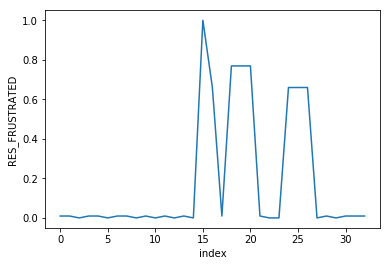

In [126]:
sns.lineplot(x='index',y='RES_FRUSTRATED',data=df_sample)

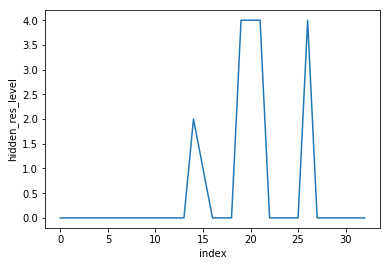

In [127]:
sns.lineplot(x='index',y='hidden_res_level',data=df_sample)

In [128]:
df_sample = df.loc[df.ITEST_id==609].rename(columns={"index": "old_index"})
df_sample.reset_index(drop=True,inplace=True)
df_sample = df_sample.reset_index()

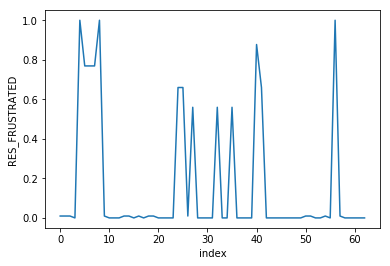

In [129]:
sns.lineplot(x='index',y='RES_FRUSTRATED',data=df_sample)

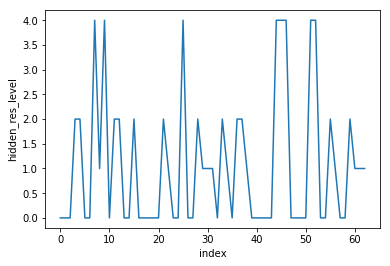

In [130]:
sns.lineplot(x='index',y='hidden_res_level',data=df_sample)

In [107]:
df_sample = df.loc[df.ITEST_id==616].rename(columns={"index": "old_index"})
df_sample.reset_index(drop=True,inplace=True)
df_sample = df_sample.reset_index()

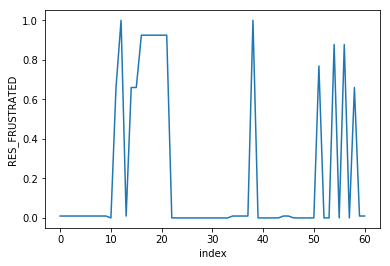

In [108]:
sns.lineplot(x='index',y='RES_FRUSTRATED',data=df_sample)

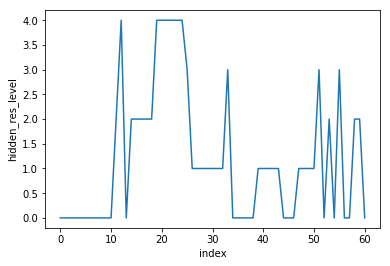

In [109]:
sns.lineplot(x='index',y='hidden_res_level',data=df_sample)

In [110]:
def agreement_measure(x,y):
    x = np.interp(x, (x.min(), x.max()), (-1, +1))
    #y = np.interp(y, (y.min(), y.max()), (-1, +1)) # y is already a rescaled value
    return euclidean(x,y)/len(x)

In [139]:
sl

{64: 425,
 134: 62,
 164: 31,
 255: 332,
 261: 483,
 283: 350,
 291: 198,
 344: 115,
 360: 349,
 372: 33,
 383: 306,
 391: 347,
 401: 165,
 410: 182,
 418: 105,
 447: 102,
 473: 178,
 474: 220,
 476: 354,
 512: 190,
 530: 515,
 546: 276,
 603: 102,
 609: 63,
 616: 61,
 621: 161,
 631: 135,
 633: 480,
 663: 355,
 672: 385,
 676: 224,
 684: 219,
 696: 95,
 709: 435,
 743: 369,
 752: 293,
 781: 261,
 782: 204,
 789: 186,
 824: 161,
 828: 548,
 832: 515,
 837: 385,
 848: 219,
 898: 289,
 954: 765,
 969: 175,
 998: 368,
 1007: 124,
 1016: 91,
 1044: 42,
 1046: 280,
 1047: 112,
 1079: 797,
 1110: 318,
 1178: 139,
 1202: 192,
 1208: 361,
 1237: 98,
 1238: 55,
 1240: 217,
 1287: 223,
 1313: 431,
 1317: 360,
 1338: 347,
 1348: 210,
 1380: 202,
 1404: 191,
 1439: 430,
 1450: 541,
 1462: 77,
 1483: 911,
 1527: 164,
 1548: 125,
 1574: 253,
 1649: 257,
 1657: 286,
 1668: 101,
 1726: 246,
 1751: 369,
 1764: 617,
 1776: 368,
 1779: 336,
 1813: 128,
 1825: 582,
 1849: 97,
 1960: 249,
 1972: 214,
 1989

In [132]:
avg_agree = []
for sid in sids:
    df_sample = df.loc[df.ITEST_id==sid].rename(columns={"index": "old_index"})
    df_sample.reset_index(drop=True,inplace=True)
    df_sample = df_sample.reset_index()
    agree = agreement_measure(df_sample.hidden_res_level.values,df_sample.RES_FRUSTRATED.values)
    print(sid, agree)
    avg_agree.append(agree)
print(np.sum(avg_agree)/len(sids))

64 0.049482082760592544
134 0.12127809118633023
164 0.14279822502904202
255 0.053465800809759434
261 0.03573909695786392
283 0.05338247171890511
291 0.04439951553271661
344 0.07727169744013794
360 0.055575573849886206
372 0.18708432450023937
383 0.053365716919114826
391 0.052708504204285765
401 0.06849282613007801
410 0.07140319960369212
418 0.10354398839729714
447 0.06557731917946538
473 0.05457750049473068
474 0.07024058875462194
476 0.05087520727586666
512 0.07102368807040642
530 0.04417722569282305
546 0.0479626310178182
603 0.09114875605758828
609 0.12366820901345547
616 0.11359170052243855
621 0.0759271140330669
631 0.08479968167720012
633 0.040355308523412
663 0.04311310403320576
672 0.0434997477659873
676 0.05676815625006959
684 0.05967864753173902
696 0.10240100428243648
709 0.04624073740401325
743 0.04674521451248783
752 0.05032400285651222
781 0.06474209023256386
782 0.07064140826947594
789 0.07104005880215662
824 0.09039019505659208
828 0.04317020405384809
832 0.04416781540

7531 0.06513386661886811
7571 0.08487677140635624
7598 0.05241599545803106
7620 0.05515317391618255
7629 0.252149206761249
7646 0.0784019431847323
7655 0.06428504277919643
7666 0.04454586674306231
7676 0.044185083953055405
7681 0.03349765562686617
7713 0.13590416169707134
7717 0.051273250264597774
7750 0.06198461042677225
7782 0.11402671208494511
3267 0.07751684755959337
3634 0.0356760632243637
3828 0.03934060225767101
4848 0.08091677406572009
662 0.04863069436134242
690 0.045306431147920996
726 0.08179542242492482
738 0.15117809051732028
763 0.05801321863836382
1301 0.1148453847408611
1345 0.12449909542576806
1456 0.11871015129939973
1469 0.04476932194460138
1539 0.08781558207275775
1557 0.06058332249065952
1568 0.15239371157741005
1570 0.048078661530760715
1575 0.11896089534027984
1635 0.17445155815270622
1670 0.0849451772837714
1701 0.06949336745583269
1704 0.032057098660862975
1752 0.07343574561234059
1818 0.11374924743903668
1823 0.07158144823336454
1866 0.10596395355257153
1868 0

In [131]:
with open('hmm_res_model_new.pickle','wb') as f:
    pickle.dump(df,f)